In [21]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [22]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [24]:
# Ajuster les options d'affichage
pd.set_option('display.max_columns', None)  # Aucune limite sur le nombre de colonnes affichées
pd.set_option('display.max_colwidth', None)  # Aucune limite sur la largeur du contenu de la colonne

In [25]:
!pwd

/root/3A/ProjetLong


In [30]:
# Correctly specifying your file path
# path_global_5s_train = "../../Dataset acoustique insectes/CSVs morceaux audio 5s/Global/train_global_recording_chunks.csv"
# path_global_5s_test = "../../Dataset acoustique insectes/CSVs morceaux audio 5s/Global/test_global_recording_chunks.csv"
# path_global_5s_val = "../../Dataset acoustique insectes/CSVs morceaux audio 5s/Global/val_global_recording_chunks.csv"

# Correctly specifying your file path
path_global_5s_train = "DataSet/CSVs_morceaux_audio_5s/Audible/train_audible_recording_chunks.csv"
path_global_5s_test = "DataSet/CSVs_morceaux_audio_5s/Audible/test_audible_recording_chunks.csv"
path_global_5s_val = "DataSet/CSVs_morceaux_audio_5s/Audible/val_audible_recording_chunks.csv"

# Using pandas to read the CSV file into a DataFrame
df_train = pd.read_csv(path_global_5s_train)
df_test = pd.read_csv(path_global_5s_test)
df_val = pd.read_csv(path_global_5s_val)

# df filtered for order 
df_train_order = df_train[df_train["label_class"] == "Insecta"]
df_test_order = df_test[df_test["label_class"] == "Insecta"]
df_val_order = df_val[df_val["label_class"] == "Insecta"]

In [31]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(df_train['label'])

label_encoder_category = LabelEncoder()
label_encoder_category.fit(df_train['label_category'])

label_encoder_soundtype = LabelEncoder()
label_encoder_soundtype.fit(df_train['sound_type'])

label_encoder_order = LabelEncoder()
label_encoder_order.fit(df_train_order['label_order'])

def clean_data(df, df_order):
    y = df['label']
    y_category = df['label_category']
    y_soundtype = df['sound_type']
    # y_kingdom = df['label_kingdom']
    # y_class = df['label_class']
    y_order = df_order['label_order']
    # y_family = df['label_family']
    # y_subfamily = df['label_subfamily']

    # Convertir les étiquettes en nombres
    y_label_encoded = label_encoder.transform(y)
    y_category_encoded = label_encoder_category.transform(y_category)
    y_soundtype_encoded = label_encoder_soundtype.transform(y_soundtype)
    y_order_encoded = label_encoder_order.transform(y_order)

    """df = df.drop(['label', 'recording_chunk_id', 'recording_id', 'annotation_chunk_id',
                  'sound_type', 'label_category', 'label_kingdom', 'label_class',
                  'label_order', 'label_family', 'label_subfamily', 'confidence_level',
                  'vocalization_type', 'code_n_ind', 'annotation_duration_prior_to_split',
                  'code_unique', 'categorie', 'ordre', 'espece', 'auteur', 'operateur',
                  'avis_operateur', 'validateur', 'espece_validee', 'permis_utilisation',
                  'date', 'GPS', 'nb_chanteurs', 'autres_especes_nb', 'autres_especes_annotees',
                  'bruits_anthropiques', 'bruits_geophoniques', 'bruit_de_fond', 'enregistreur',
                  'micro', 'bonnette', 'expansion_de_temps', 'localisation', 'annotation',
                  'annotation_exhaustive', 'photo', 'stereo', 'notes', 'annotation_initial_time',
                  'annotation_final_time', 'chunk_initial_time', 'chunk_final_time', 'sampling_rate',
                  'BPS'], axis=1)

    df = df.select_dtypes(['number'])"""
    
    df['duree'] = df['duree_min'] * 60 + df['duree_sec']
    df = df[['max_frequency', 'min_frequency', 'avg_frequency', 'duree']]
    df['min_frequency'] = df['min_frequency'].astype(int)
    df['max_frequency'] = df['max_frequency'].astype(int)

    # Gestion des valeurs manquantes
    #df.fillna(df.mean(), inplace=True)
    df = df.dropna()

    # Gestion des variables catégorielles
    df = pd.get_dummies(df)

    X = df

    # For the order label
    df_order['duree'] = df_order['duree_min'] * 60 + df_order['duree_sec']
    df_order = df_order[['max_frequency', 'min_frequency', 'avg_frequency', 'duree']]
    df_order['min_frequency'] = df_order['min_frequency'].astype(int)
    df_order['max_frequency'] = df_order['max_frequency'].astype(int)

    # Gestion des valeurs manquantes
    #df.fillna(df.mean(), inplace=True)
    df_order = df_order.dropna()

    # Gestion des variables catégorielles
    df_order = pd.get_dummies(df_order)

    X_order = df_order


    return X, y_label_encoded, y_soundtype_encoded, y_category_encoded, y_order_encoded, X_order

X_train, y_train_label, y_train_soundtype, y_train_category, y_train_order, X_train_order = clean_data(df_train, df_train_order)
X_test, y_test_label, y_test_soundtype, y_test_category, y_test_order, X_test_order = clean_data(df_test, df_test_order)
X_val, y_val_label, y_val_soundtype, y_val_category, y_val_order, X_val_order = clean_data(df_val,df_val_order)

/tmp/ipykernel_10067/3279597962.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['min_frequency'] = df['min_frequency'].astype(int)
/tmp/ipykernel_10067/3279597962.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['max_frequency'] = df['max_frequency'].astype(int)
/tmp/ipykernel_10067/3279597962.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://

Évaluation LightGBM :
Accuracy sur l'ensemble de validation: 0.7722772277227723
              precision    recall  f1-score   support

           0       0.56      0.62      0.59         8
           1       0.56      1.00      0.71        10
           2       0.67      1.00      0.80         4
           3       0.96      1.00      0.98        22
           4       0.74      0.84      0.79        38
           5       0.89      1.00      0.94         8
           6       0.71      1.00      0.83        10
           7       0.46      0.50      0.48        12
           8       0.67      0.60      0.63        10
           9       1.00      1.00      1.00         5
          10       0.82      1.00      0.90        23
          11       1.00      1.00      1.00         7
          12       0.71      0.48      0.57        25
          13       0.38      0.60      0.46         5
          14       0.55      0.40      0.46        15
          15       0.76      0.95      0.84        20
 

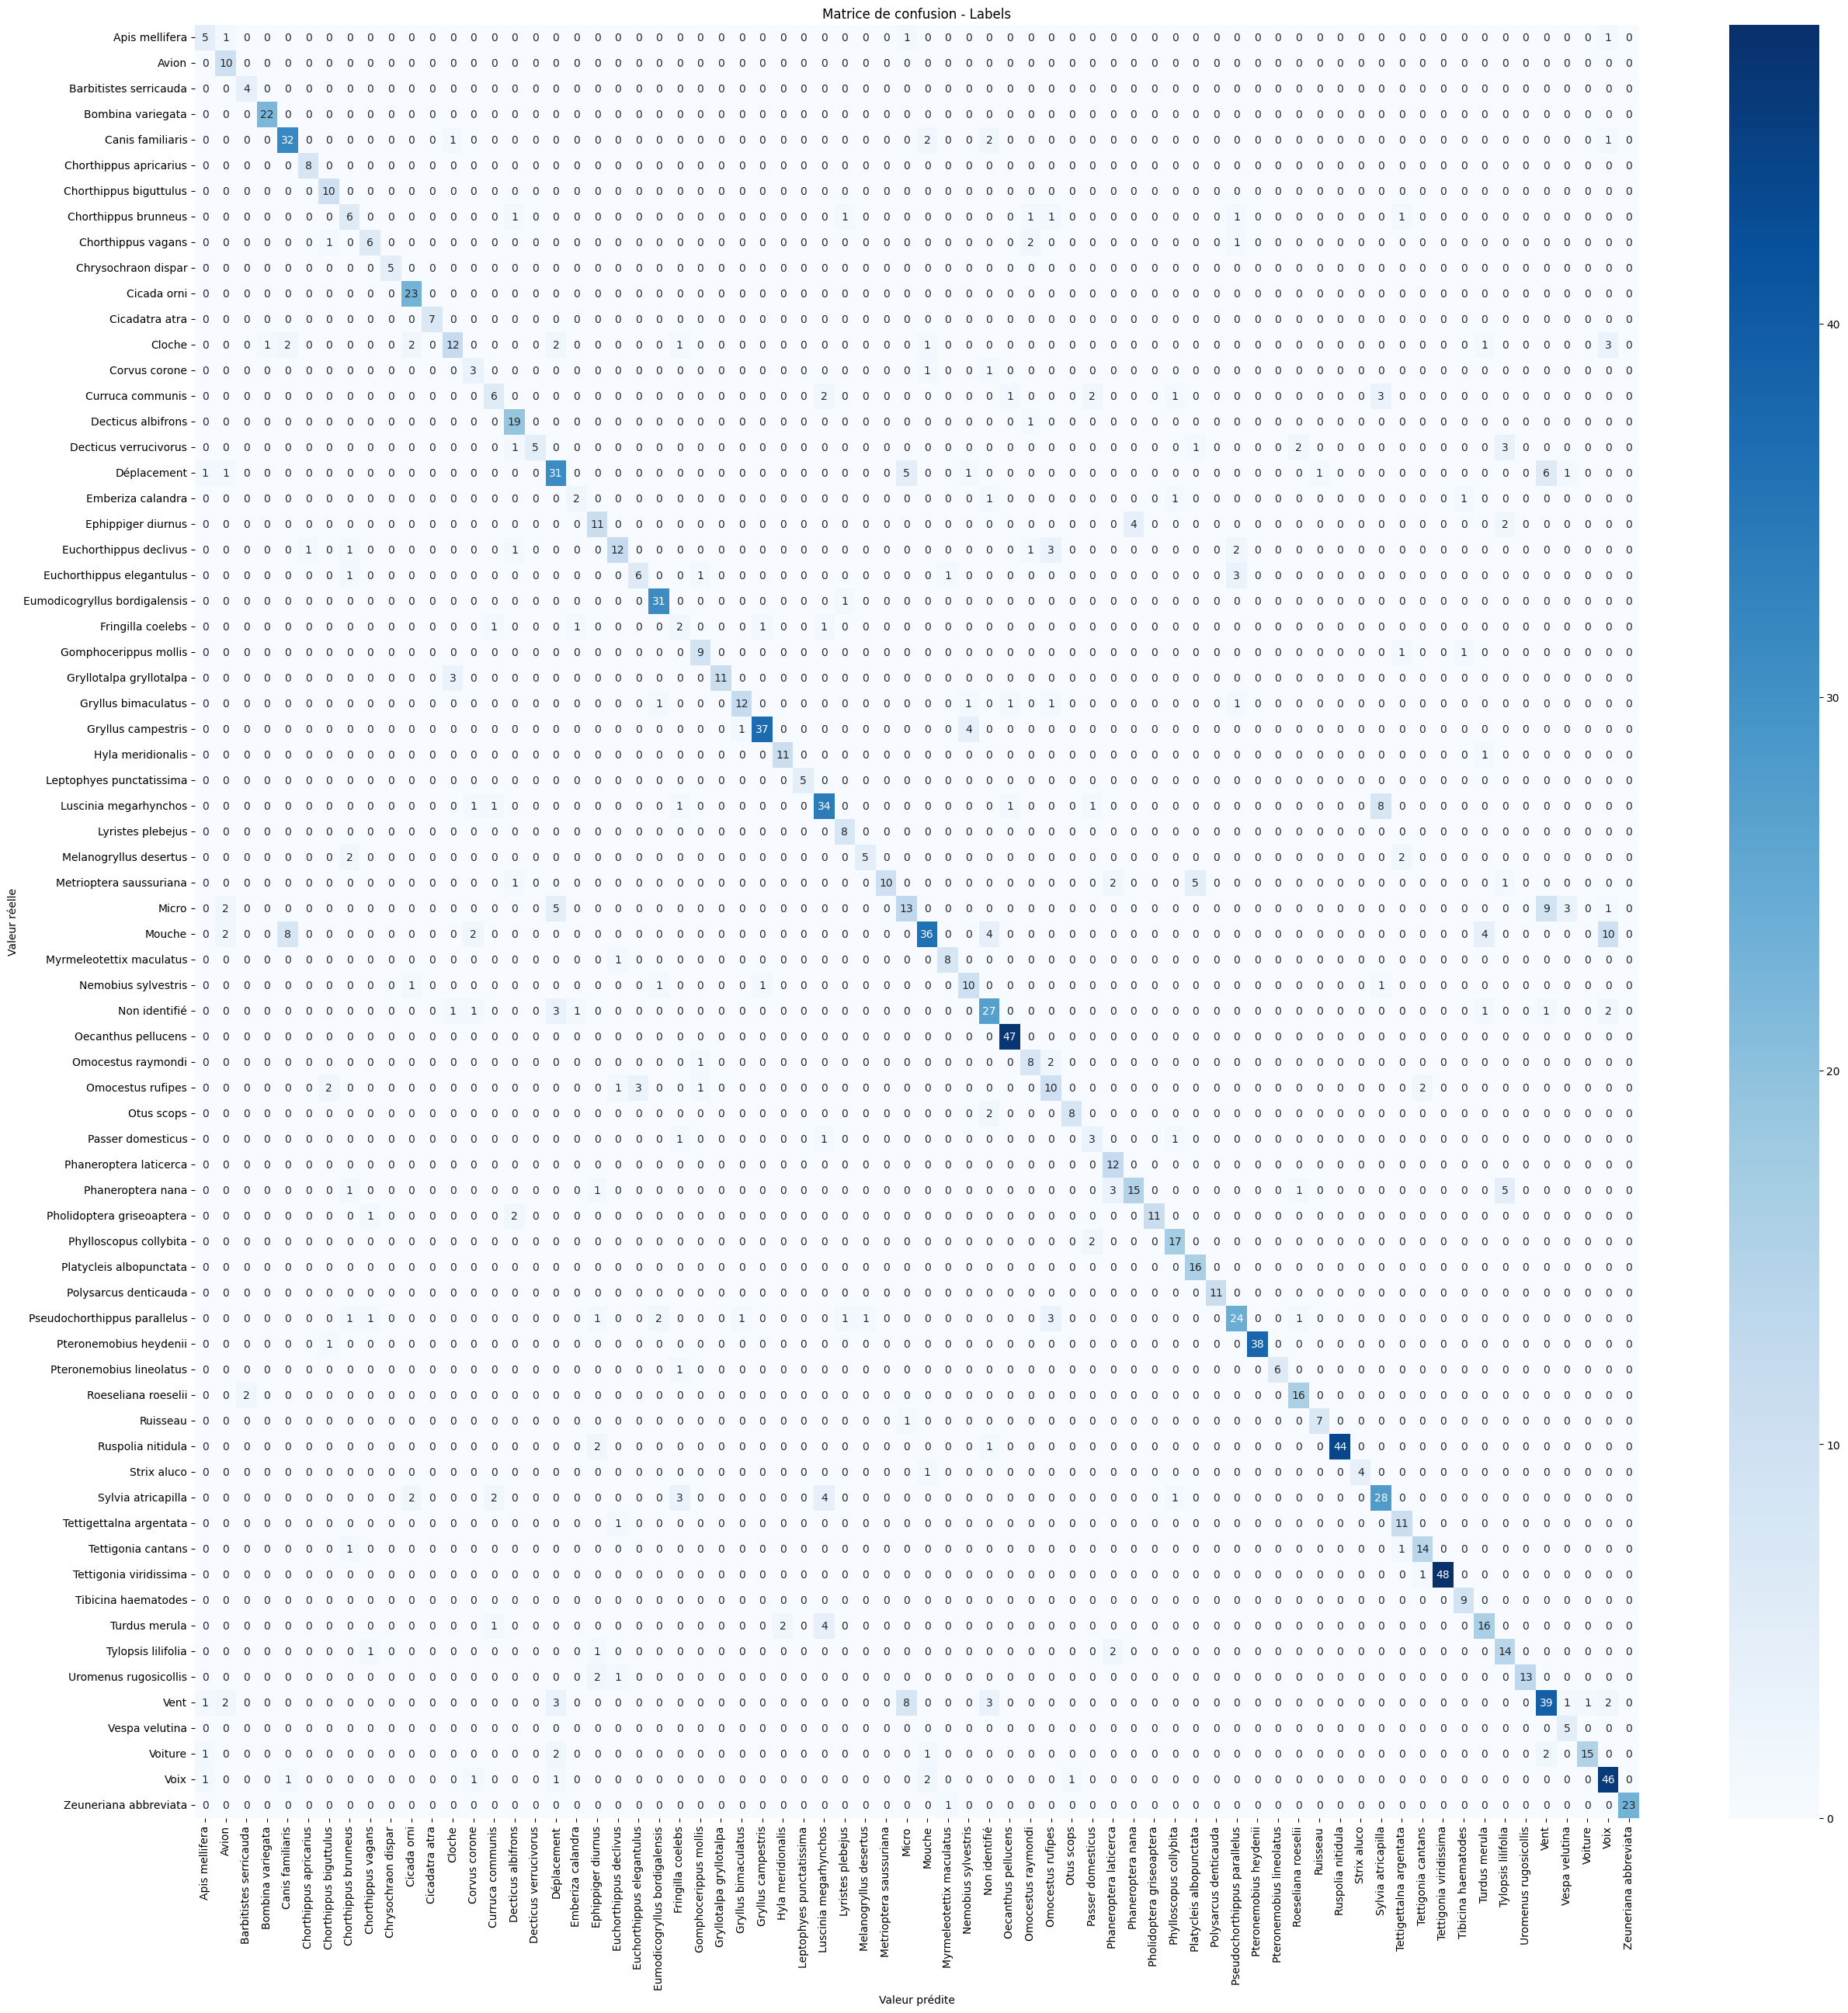

In [32]:
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
################# LABELS #########################################

# Initialiser et entraîner le modèle XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', verbosity=2)

# Calculer les poids des classes
# 'balanced' ajuste automatiquement les poids inversément proportionnels aux fréquences des classes
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_label), y=y_train_label)

# Créer un dictionnaire des poids pour faciliter l'application des poids aux échantillons
weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Appliquer les poids aux instances de formation
sample_weight = np.array([weights_dict[y] for y in y_train_label])

# Entraînement du modèle avec les poids des instances
xgb_model.fit(X_train, y_train_label, sample_weight=sample_weight)

predictions_label = xgb_model.predict(X_test)

# Évaluation LightGBM
print("Évaluation LightGBM :")
print("Accuracy sur l'ensemble de validation:", accuracy_score(y_test_label, predictions_label))
print(classification_report(y_test_label, predictions_label))

# matrice de confusion
cm = confusion_matrix(y_test_label, predictions_label)
y_test_inversed = label_encoder.inverse_transform(y_test_label)

unique_labels = np.unique(y_test_inversed)

plt.figure(figsize=(30,30))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=unique_labels, yticklabels=unique_labels)
plt.title('Matrice de confusion - Labels')
plt.ylabel('Valeur réelle')
plt.xlabel('Valeur prédite')
plt.show()

Évaluation LightGBM :
Accuracy sur l'ensemble de validation sound type: 0.4695898161244696
              precision    recall  f1-score   support

           0       0.88      0.43      0.58      1040
           1       0.04      0.93      0.07        14
           2       0.37      0.55      0.44       360

    accuracy                           0.47      1414
   macro avg       0.43      0.64      0.36      1414
weighted avg       0.74      0.47      0.54      1414



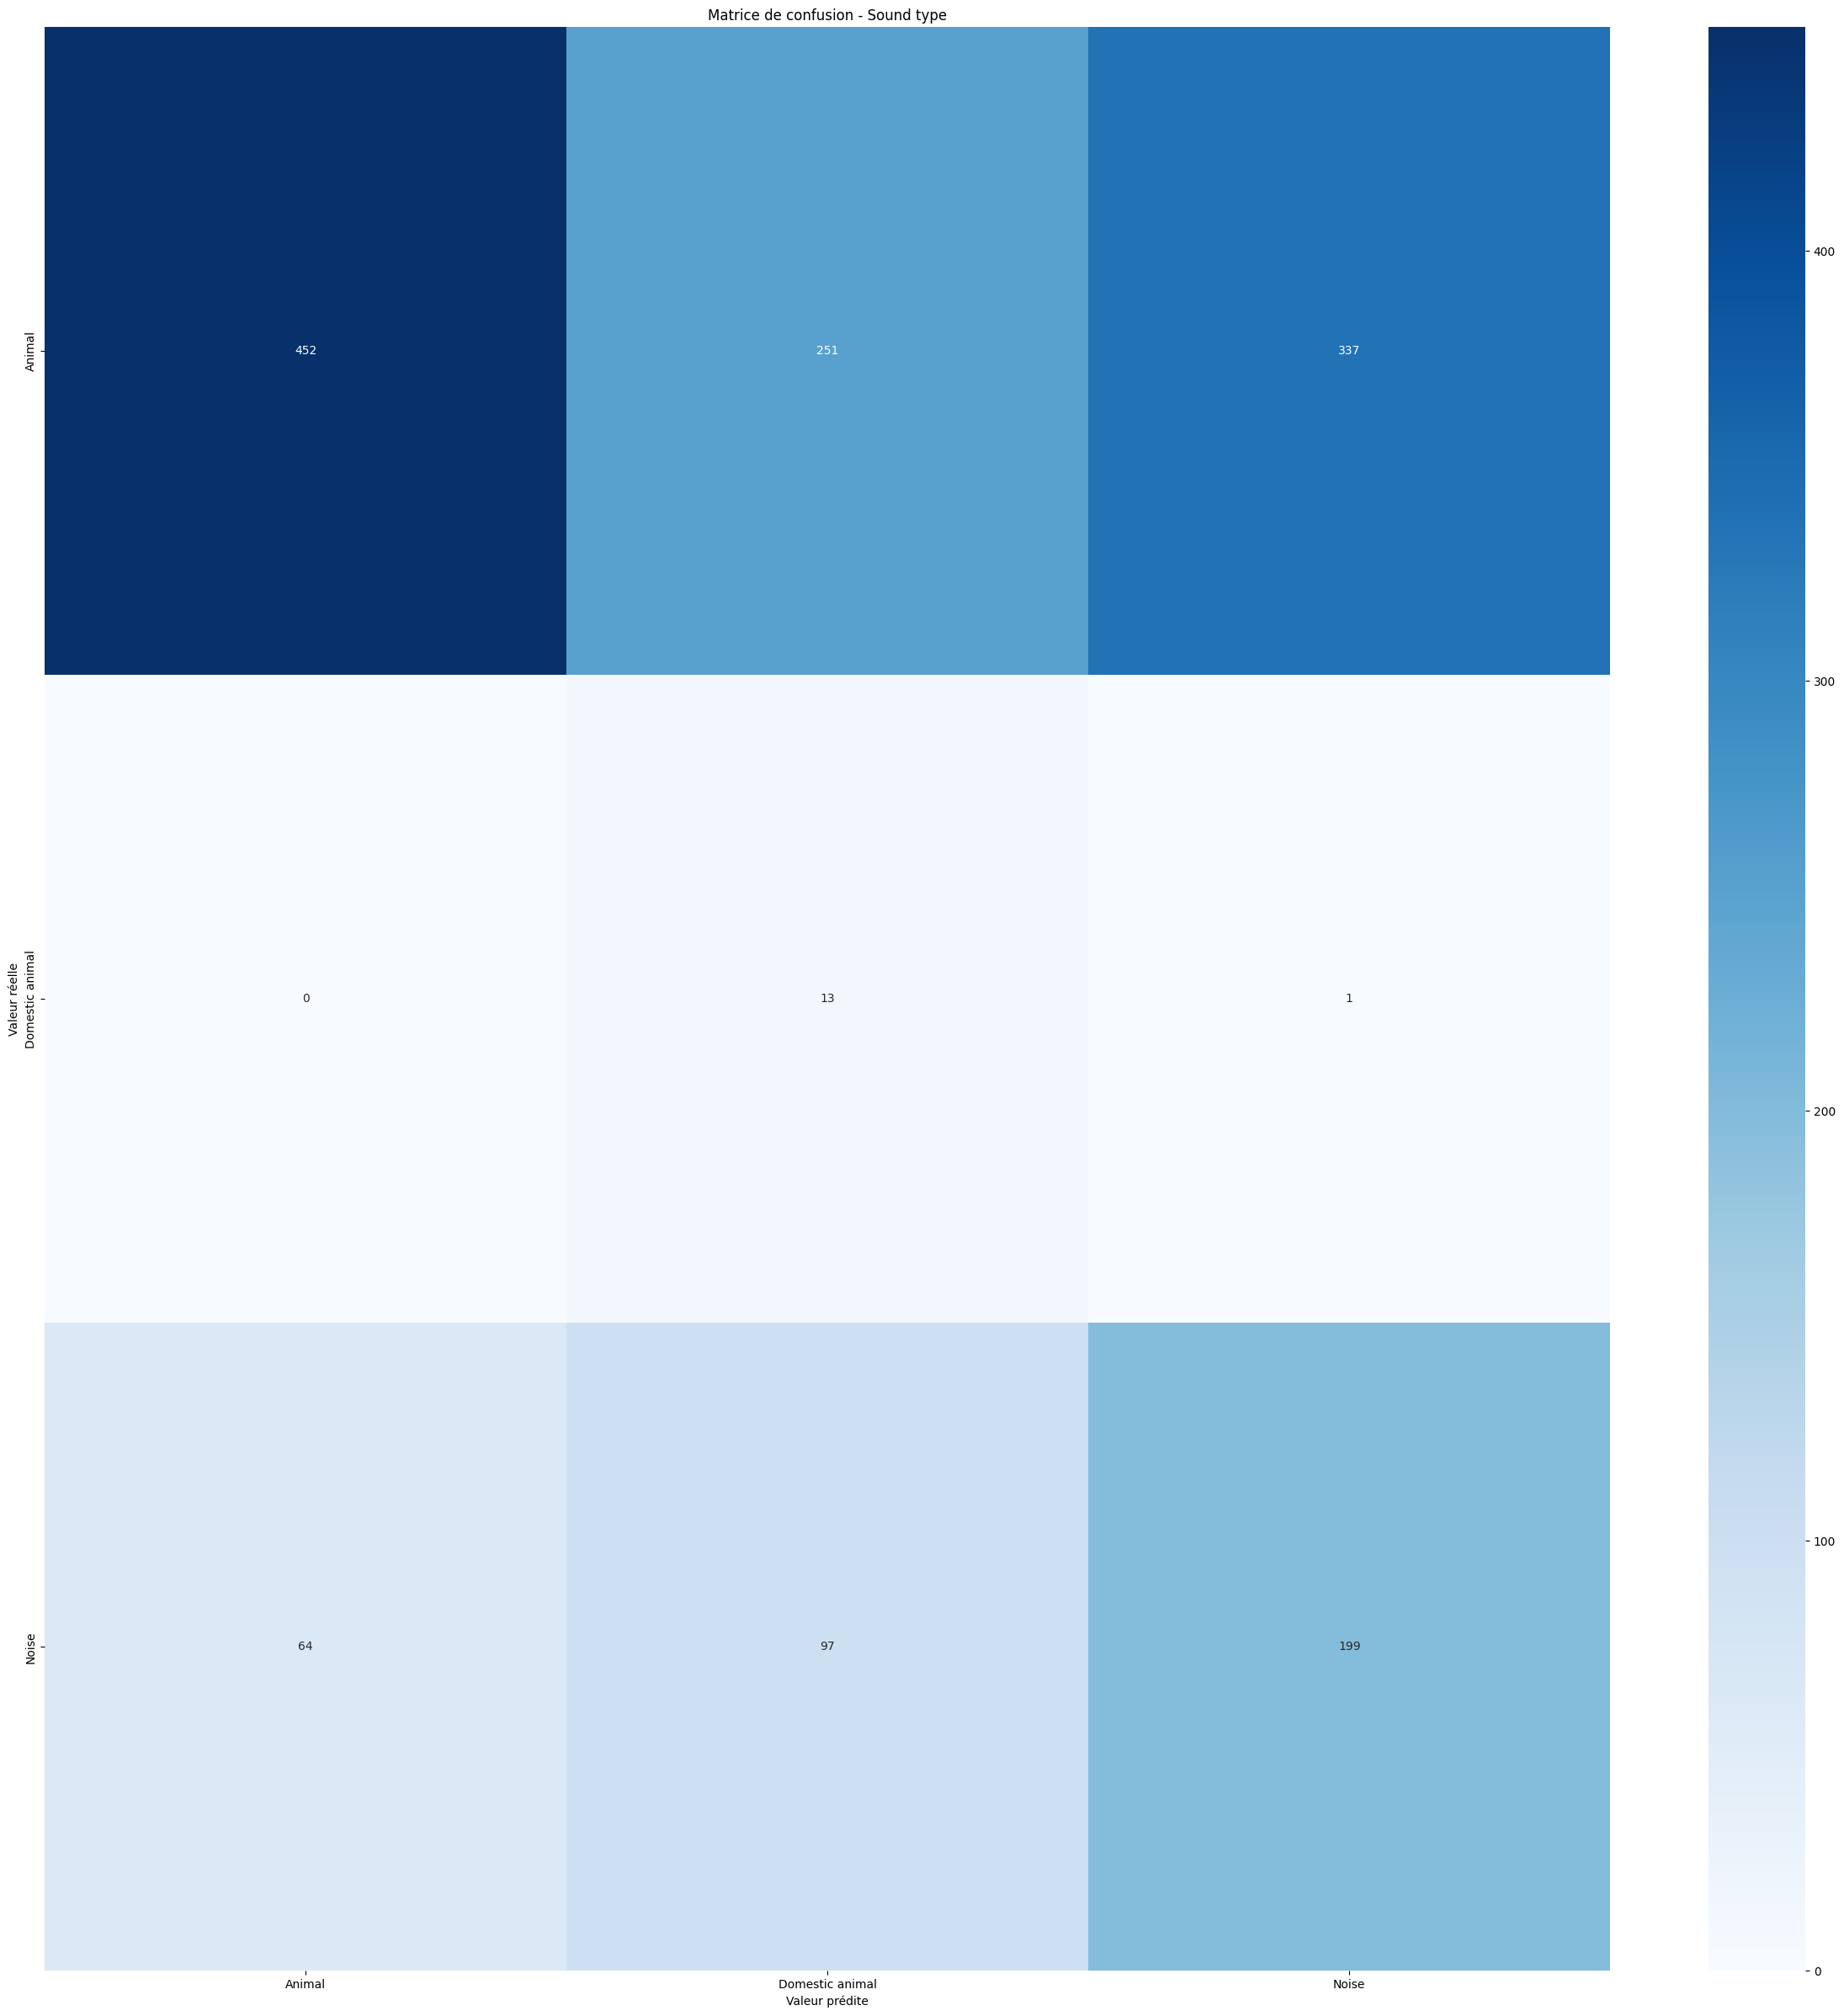

In [48]:
############################### Soundtype #################################

# Initialiser et entraîner le modèle XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', verbosity=2)

# Calculer les poids des classes
# 'balanced' ajuste automatiquement les poids inversément proportionnels aux fréquences des classes
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_soundtype), y=y_train_soundtype)

# Créer un dictionnaire des poids pour faciliter l'application des poids aux échantillons
weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Appliquer les poids aux instances de formation
sample_weight = np.array([weights_dict[y] for y in y_train_soundtype])

# Entraînement du modèle avec les poids des instances
xgb_model.fit(X_train, y_train_soundtype, sample_weight=sample_weight)

predictions_soundtype = xgb_model.predict(X_test)

# Évaluation LightGBM
print("Évaluation LightGBM :")
print("Accuracy sur l'ensemble de validation sound type:", accuracy_score(y_test_soundtype, predictions_soundtype))
print(classification_report(y_test_soundtype, predictions_soundtype))

# matrice de confusion
cm = confusion_matrix(y_test_soundtype, predictions_soundtype)
y_test_inversed = label_encoder_soundtype.inverse_transform(y_test_soundtype)

unique_labels = np.unique(y_test_inversed)

plt.figure(figsize=(30,30))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=unique_labels, yticklabels=unique_labels)
plt.title('Matrice de confusion - Sound type')
plt.ylabel('Valeur réelle')
plt.xlabel('Valeur prédite')
plt.show()

Évaluation LightGBM :
Accuracy sur l'ensemble de validation Category: 0.20297029702970298
              precision    recall  f1-score   support

           0       0.31      0.12      0.18       226
           1       0.09      1.00      0.17        34
           2       0.00      0.00      0.00       181
           3       0.00      0.00      0.00        66
           4       0.08      0.25      0.12        68
           5       0.12      0.58      0.20        59
           6       0.04      0.77      0.08        13
           7       0.17      0.34      0.22        38
           8       0.93      0.21      0.34       729

    accuracy                           0.20      1414
   macro avg       0.19      0.36      0.15      1414
weighted avg       0.54      0.20      0.23      1414



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


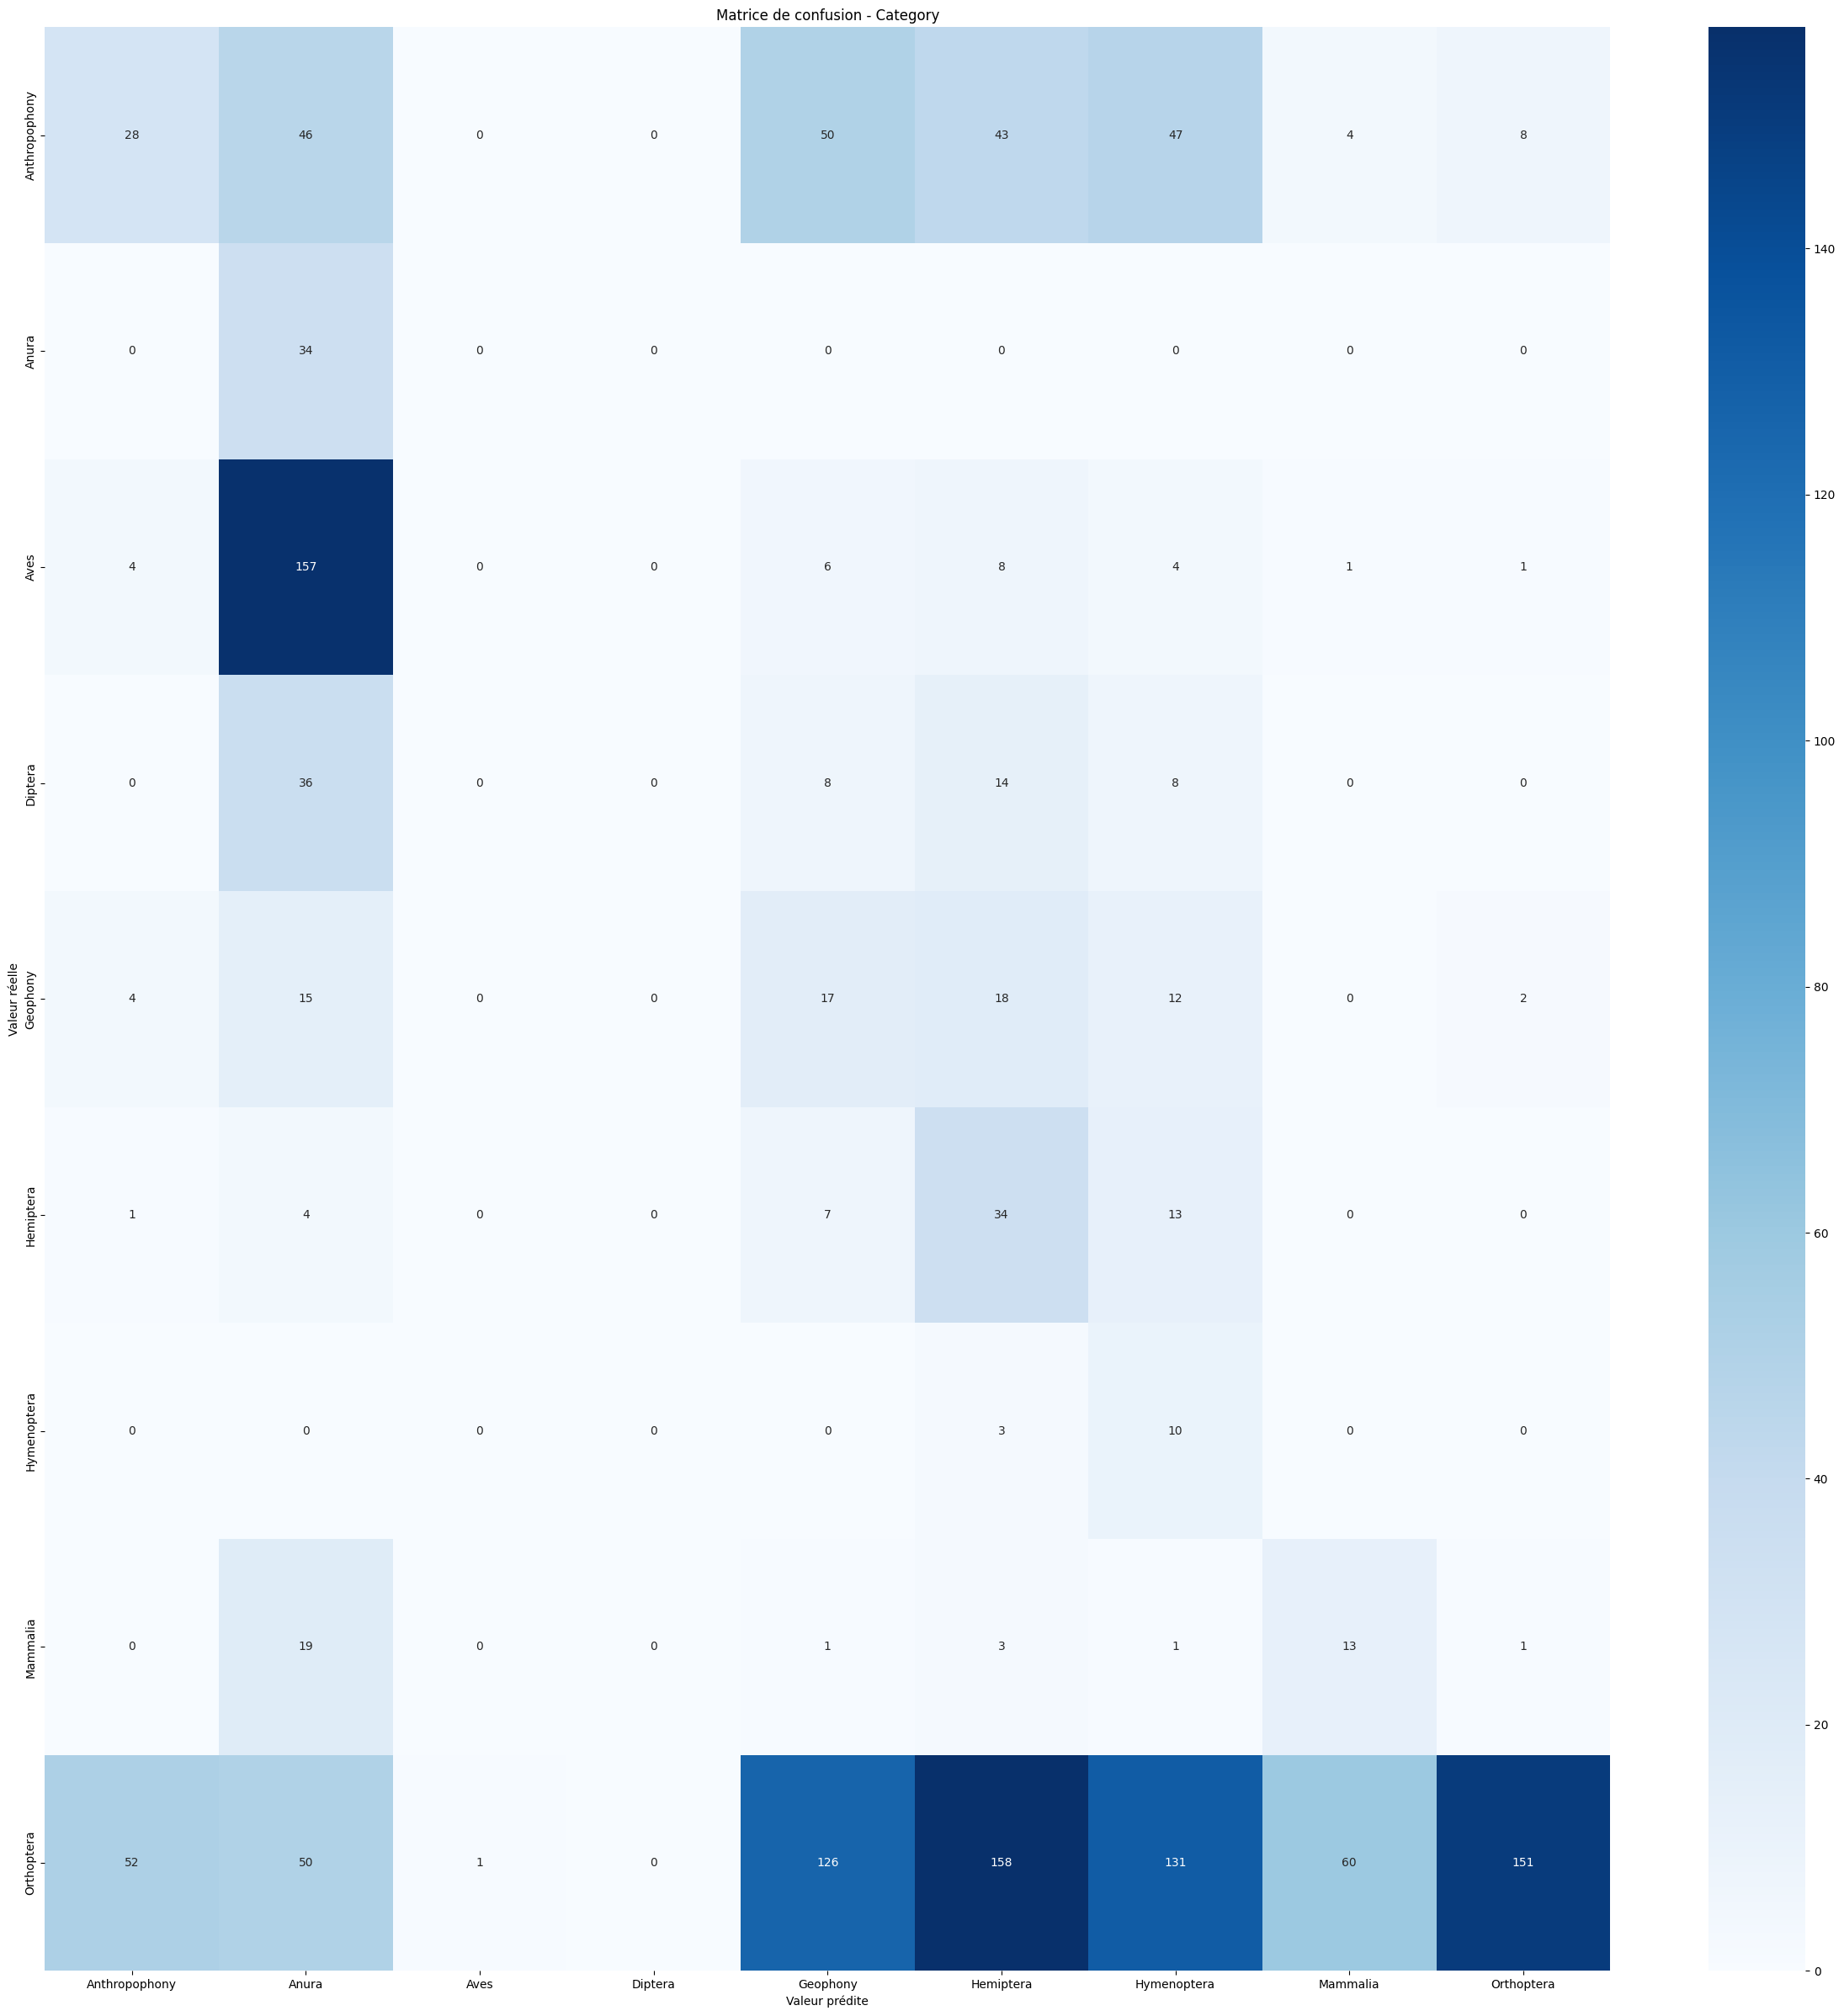

In [49]:
#################### Category ###############################

# Initialiser et entraîner le modèle XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', verbosity=2)

# Calculer les poids des classes
# 'balanced' ajuste automatiquement les poids inversément proportionnels aux fréquences des classes
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_category), y=y_train_category)

# Créer un dictionnaire des poids pour faciliter l'application des poids aux échantillons
weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Appliquer les poids aux instances de formation
sample_weight = np.array([weights_dict[y] for y in y_train_category])

# Entraînement du modèle avec les poids des instances
xgb_model.fit(X_train, y_train_category, sample_weight=sample_weight)

predictions_category= xgb_model.predict(X_test)

# Évaluation LightGBM
print("Évaluation LightGBM :")
print("Accuracy sur l'ensemble de validation Category:", accuracy_score(y_test_category, predictions_category))
print(classification_report(y_test_category, predictions_category))

# matrice de confusion
cm = confusion_matrix(y_test_category, predictions_category)
y_test_inversed = label_encoder_category.inverse_transform(y_test_category)

unique_labels = np.unique(y_test_inversed)

plt.figure(figsize=(30,30))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=unique_labels, yticklabels=unique_labels)
plt.title('Matrice de confusion - Category')
plt.ylabel('Valeur réelle')
plt.xlabel('Valeur prédite')
plt.show()

Évaluation LightGBM :
Accuracy sur l'ensemble de validation Order : 0.9700115340253749
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        66
           1       0.75      0.92      0.82        59
           2       0.81      1.00      0.90        13
           3       0.99      0.97      0.98       729

    accuracy                           0.97       867
   macro avg       0.89      0.96      0.92       867
weighted avg       0.97      0.97      0.97       867



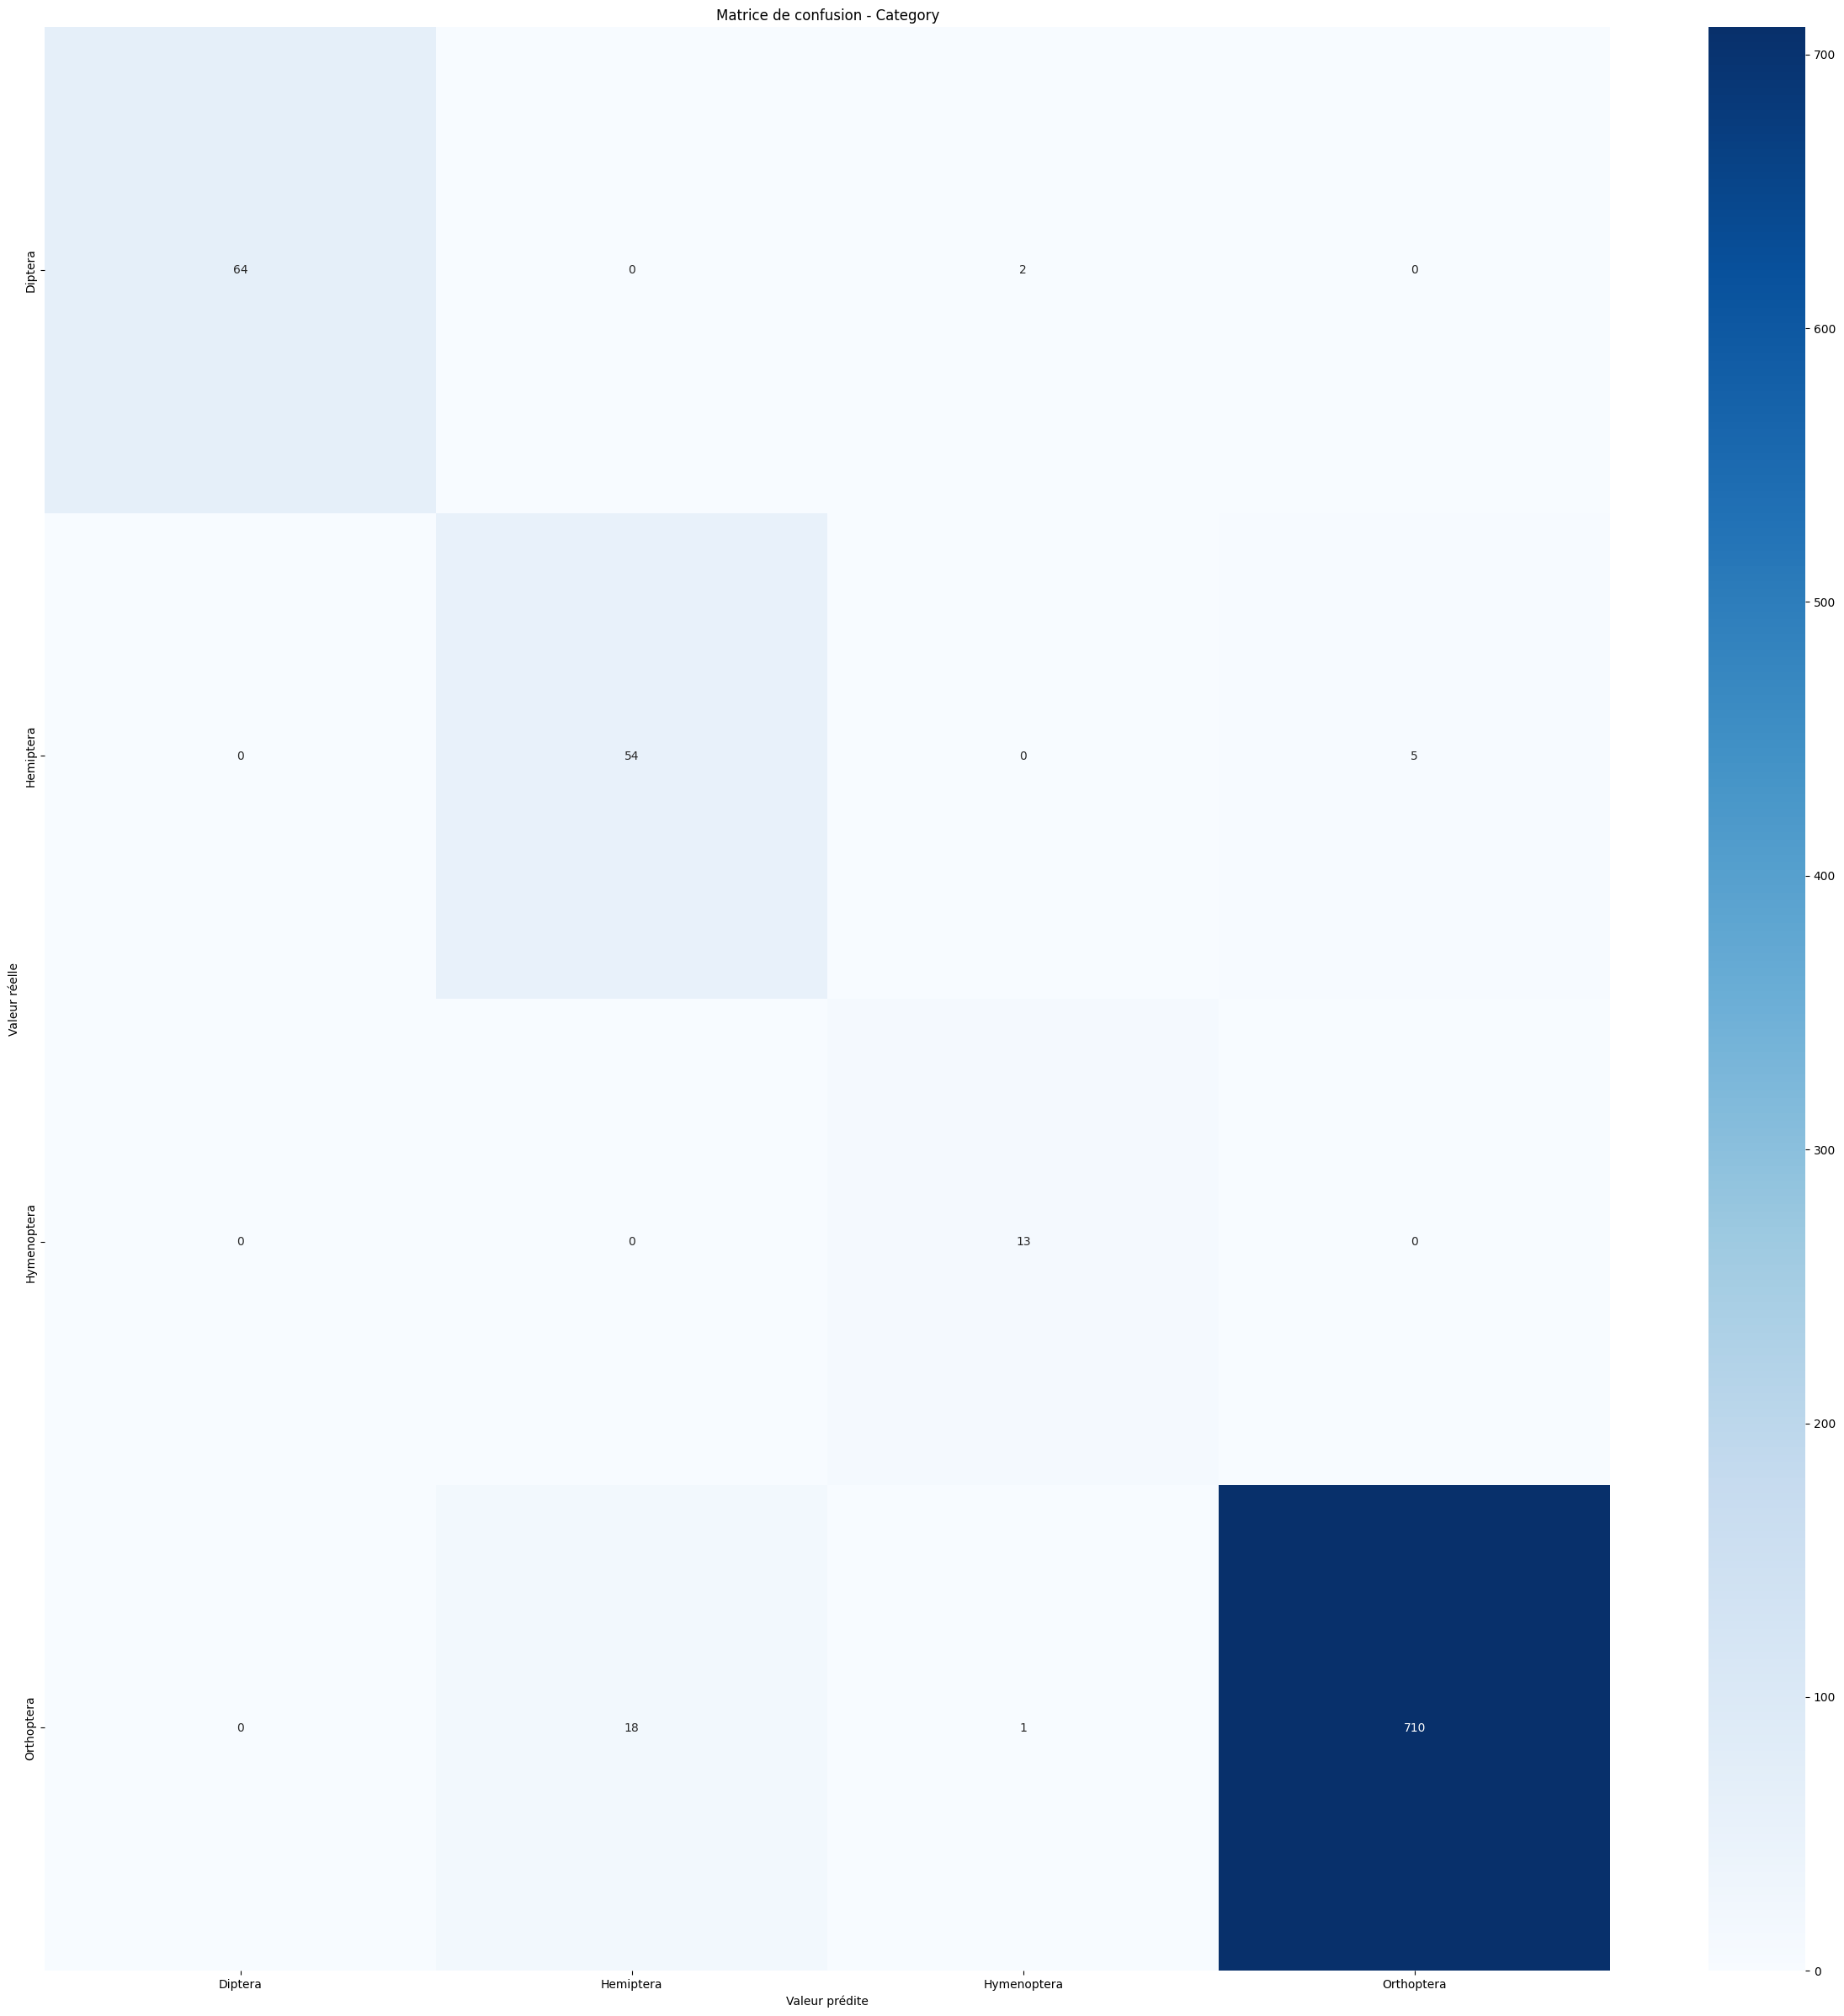

In [34]:
#################### Order = Insecte ###############################

# Initialiser et entraîner le modèle XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', verbosity=2)

# Calculer les poids des classes
# 'balanced' ajuste automatiquement les poids inversément proportionnels aux fréquences des classes
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_order), y=y_train_order)

# Créer un dictionnaire des poids pour faciliter l'application des poids aux échantillons
weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Appliquer les poids aux instances de formation
sample_weight = np.array([weights_dict[y] for y in y_train_order])

# Entraînement du modèle avec les poids des instances
xgb_model.fit(X_train_order, y_train_order, sample_weight=sample_weight)

predictions_insecte= xgb_model.predict(X_test_order)

# Évaluation LightGBM
print("Évaluation LightGBM :")
print("Accuracy sur l'ensemble de validation Order :", accuracy_score(y_test_order, predictions_insecte))
print(classification_report(y_test_order, predictions_insecte))

# matrice de confusion
cm = confusion_matrix(y_test_order, predictions_insecte)
y_test_inversed = label_encoder_order.inverse_transform(y_test_order)

unique_labels = np.unique(y_test_inversed)

plt.figure(figsize=(30,30))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=unique_labels, yticklabels=unique_labels)
plt.title('Matrice de confusion - Category')
plt.ylabel('Valeur réelle')
plt.xlabel('Valeur prédite')
plt.show()

In [ ]:
## Metric passif/actif 